In [1]:
# Standard python helper libraries.
import os, sys, re, json, time, wget, csv, string, time, random
import itertools, collections

# NumPy
import numpy as np

# NLTK for NLP utils
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

from keras import backend as K
from keras.models import Sequential
from keras.layers import GaussianNoise, Dropout, Dense, Embedding, MaxPool1D, GlobalMaxPool1D, Conv1D, LSTM, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import Callback

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

from pymagnitude import *

[nltk_data] Downloading package punkt to /home/renzeer/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/renzeer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Using TensorFlow backend.


# Binary Classifier for Cardiovascular Disease using a Convolutional Neural Network

In this notebook, we will be building a model for classifying a sentence from an EHR note for the presence of cardiovascular disease. The model will be trained using a convoultional neural network (CNN). 

## Text Preprocessing

In [2]:
ehr_notes = []
with open('data/ehr_samples.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:     
        if int(row['SpecialtyID']) in [39, 6, 16, 37, 11, 12, 29, 26, 7, 21, 19, 10, 2, 18]:
            continue
        elif int(row['SpecialtyID']) != 4:
            ehr_notes.append(['Other', row['Note']])
        else:
            ehr_notes.append([row['Specialty'], row['Note']])

print(ehr_notes[0])
print(ehr_notes[2])

['Other', 'PAST MEDICAL HISTORY:, He has difficulty climbing stairs, difficulty with airline seats, tying shoes, used to public seating, and lifting objects off the floor.  He exercises three times a week at home and does cardio.  He has difficulty walking two blocks or five flights of stairs.  Difficulty with snoring.  He has muscle and joint pains including knee pain, back pain, foot and ankle pain, and swelling.  He has gastroesophageal reflux disease.,PAST SURGICAL HISTORY:, Includes reconstructive surgery on his right hand 13 years ago.  ,SOCIAL HISTORY:, He is currently single.  He has about ten drinks a year.  He had smoked significantly up until several months ago.  He now smokes less than three cigarettes a day.,FAMILY HISTORY:, Heart disease in both grandfathers, grandmother with stroke, and a grandmother with diabetes.  Denies obesity and hypertension in other family members.,CURRENT MEDICATIONS:, None.,ALLERGIES:,  He is allergic to Penicillin.,MISCELLANEOUS/EATING HISTORY:

## Natural Langauge Processing

In [3]:
ehr_notes_clean = []
for record in ehr_notes:
    sentences = []
    
    sent_text = nltk.sent_tokenize(record[1])
    for sent in sent_text:
        tokens = word_tokenize(sent)

        # convert to lower case
        tokens = [w.lower() for w in tokens]

        # remove punctuation from each word
        table = str.maketrans('', '', string.punctuation)
        tokens = [w.translate(table) for w in tokens]

        # filter out stop words
        stop_words = set(stopwords.words('english'))
        tokens = [w for w in tokens if not w in stop_words]

#         # stem words
#         porter = PorterStemmer()
#         tokens = [porter.stem(word) for word in tokens]

        # remove blanks
        tokens = [w for w in tokens if w != '']
        
        clean_sentence = '<s> <s> ' + ' '.join(tokens) + ' </s> </s>'
        sentences.append(clean_sentence)
        
    ehr_notes_clean.append([record[0], ' '.join(sentences)])

random.Random(4).shuffle(ehr_notes_clean)

print(ehr_notes_clean[0])
print(ehr_notes_clean[1])

['Cardiovascular', '<s> <s> procedures undertaken1 </s> </s> <s> <s> left coronary system cineangiography2 </s> </s> <s> <s> right coronary system cineangiography3 </s> </s> <s> <s> cineangiography svg om4 </s> </s> <s> <s> cineangiography lima lad5 </s> </s> <s> <s> left ventriculogram6 </s> </s> <s> <s> aortogram7 </s> </s> <s> <s> percutaneous intervention left circumflex obtuse marginal branch plano balloon angioplasty unable pass stent narrative risks benefits explained patient informed consent obtained </s> </s> <s> <s> patient brought cardiac catheterization suite </s> </s> <s> <s> right groin prepped usual sterile fashion </s> </s> <s> <s> right common femoral artery cannulated using modified seldinger technique long 6french ao sheath introduced secondary tortuous aorta </s> </s> <s> <s> next judkins left catheter used engage left coronary system </s> </s> <s> <s> cineangiography recorded multiple views </s> </s> <s> <s> next judkins right catheter used engage right coronary sy

## Word Embedding

The first step is to load in our word embedding, which is trained on text from Wikipedia, Pubmed, and Pubmed Central. We load our word embedding through a tool called Magnitude. A full exploration of the word embedding and Magnitude can be found in the Introduction notebook.

In [4]:
notes = list(np.array(ehr_notes_clean)[:,1])
lengths = [len(note.split(' ')) for note in notes]
MAX_WORDS = max(lengths) # The maximum number of words the sequence model will consider
med_vectors = Magnitude("data/wikipedia-pubmed-and-PMC-w2v.magnitude", pad_to_length=MAX_WORDS)

## Defining our Training and Test Data

Before we can start building our neural networks, we first have to define our datasets. Specifically, we have to break up our EHR data so that we have records that we can train on and records that are exclusively used to test on. Maintaining a separate set for testing ensures we avoid overfitting our data.

We will use some built-in functions provided by Magnitude that helps encode our classes/categories. We then partition our data into our train and test sets. For each set we have both data and labels. Initially, we will be making these partitions small to make iterating through model development much quicker. However, once the models are developed, we will expand our datasets to include all of our data. To ensure we defined our data correctly, we can print a few lines from the two sets.

In [5]:
len(ehr_notes_clean)

2552

In [6]:
add_intent, intent_to_int, int_to_intent = MagnitudeUtils.class_encoding()

x_train = [ehr_note[1].split(' ') for ehr_note in ehr_notes_clean[:2200]]
x_test = [ehr_note[1].split(' ') for ehr_note in ehr_notes_clean[2201:]]

y_train = [add_intent(ehr_note[0]) for ehr_note in ehr_notes_clean[:2200]]
y_test = [add_intent(ehr_note[0]) for ehr_note in ehr_notes_clean[2201:]]

y_train = list(np.array(y_train).reshape(len(y_train)))
y_test = list(np.array(y_test).reshape(len(y_test)))

num_training = len(x_train)
num_test = len(x_test)
num_outputs = int(max(max(y_train), max(y_test))) + 1

print(int_to_intent(0))

print("First line of train/test data:")
print("\t", x_train[0])
print("\t", y_train[0], int_to_intent(y_train[0]))
print("\t", x_test[0])
print("\t", y_test[0], int_to_intent(y_test[0]))
print("Second line of train/test data:")
print("\t", x_train[1])
print("\t", y_train[1], int_to_intent(y_train[1]))
print("\t", x_test[1])
print("\t", y_test[1], int_to_intent(y_test[1]))

Cardiovascular
First line of train/test data:
	 ['<s>', '<s>', 'procedures', 'undertaken1', '</s>', '</s>', '<s>', '<s>', 'left', 'coronary', 'system', 'cineangiography2', '</s>', '</s>', '<s>', '<s>', 'right', 'coronary', 'system', 'cineangiography3', '</s>', '</s>', '<s>', '<s>', 'cineangiography', 'svg', 'om4', '</s>', '</s>', '<s>', '<s>', 'cineangiography', 'lima', 'lad5', '</s>', '</s>', '<s>', '<s>', 'left', 'ventriculogram6', '</s>', '</s>', '<s>', '<s>', 'aortogram7', '</s>', '</s>', '<s>', '<s>', 'percutaneous', 'intervention', 'left', 'circumflex', 'obtuse', 'marginal', 'branch', 'plano', 'balloon', 'angioplasty', 'unable', 'pass', 'stent', 'narrative', 'risks', 'benefits', 'explained', 'patient', 'informed', 'consent', 'obtained', '</s>', '</s>', '<s>', '<s>', 'patient', 'brought', 'cardiac', 'catheterization', 'suite', '</s>', '</s>', '<s>', '<s>', 'right', 'groin', 'prepped', 'usual', 'sterile', 'fashion', '</s>', '</s>', '<s>', '<s>', 'right', 'common', 'femoral', 'arter

## Defining Custom Callback Function

In [7]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Defining Model

In [8]:
STD_DEV = 0.01 # Deviation of noise for Gaussian Noise applied to the embeddings
DROPOUT_RATIO = .5 # The ratio to dropout
BATCH_SIZE = 100 # The number of examples per train/validation step
EPOCHS = 100 # The number of times to repeat through all of the training data
LEARNING_RATE = .01 # The learning rate for the optimizer
HIDDEN_UNITS = 100

model = Sequential()
model.add(GaussianNoise(STD_DEV, input_shape=(MAX_WORDS, med_vectors.dim)))
model.add(Bidirectional(LSTM(HIDDEN_UNITS, activation='tanh'), merge_mode='concat'))
model.add(Dropout(DROPOUT_RATIO))
model.add(Dense(num_outputs, activation='softmax'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', f1])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_1 (GaussianNo (None, 2339, 200)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               240800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 402       
Total params: 241,202
Trainable params: 241,202
Non-trainable params: 0
_________________________________________________________________


## Training Batches and Epochs

In [9]:
training_batches = MagnitudeUtils.batchify(x_train, y_train, BATCH_SIZE) # Split the training data into batches
num_batches_per_epoch_train = int(np.ceil(num_training/float(BATCH_SIZE)))
test_batches = MagnitudeUtils.batchify(x_test, y_test, BATCH_SIZE)  # Split the test data into batches
num_batches_per_epoch_test = int(np.ceil(num_test/float(BATCH_SIZE)))


# Generates batches of the transformed training data
train_batch_generator = (
  (
    med_vectors.query(x_train_batch), # Magnitude will handle converting the 2D array of text into the 3D word vector representations!
    MagnitudeUtils.to_categorical(y_train_batch, num_outputs) # Magnitude will handle converting the class labels into one-hot encodings!
  ) for x_train_batch, y_train_batch in training_batches
)

# Generates batches of the transformed test data
test_batch_generator = (
  (
    med_vectors.query(x_test_batch), # Magnitude will handle converting the 2D array of text into the 3D word vector representations!
    MagnitudeUtils.to_categorical(y_test_batch, num_outputs) # Magnitude will handle converting the class labels into one-hot encodings!
  ) for x_test_batch, y_test_batch in test_batches
)

# Start training
model.fit_generator(
    generator = train_batch_generator,
    steps_per_epoch = num_batches_per_epoch_train,
    validation_data = test_batch_generator,
    validation_steps = num_batches_per_epoch_test,
    epochs = EPOCHS,
)

Epoch 1/100
22/22 [==============================] - 1166s 53s/step - loss: 0.4773 - acc: 0.8464 - f1: 0.8464 - val_loss: 0.3616 - val_acc: 0.8832 - val_f1: 0.8832
Epoch 2/100
22/22 [==============================] - 209s 9s/step - loss: 0.3877 - acc: 0.8505 - f1: 0.8505 - val_loss: 0.3205 - val_acc: 0.8832 - val_f1: 0.8832
Epoch 3/100
22/22 [==============================] - 235s 11s/step - loss: 0.3752 - acc: 0.8582 - f1: 0.8582 - val_loss: 0.3216 - val_acc: 0.8832 - val_f1: 0.8832
Epoch 4/100
22/22 [==============================] - 236s 11s/step - loss: 0.3402 - acc: 0.8555 - f1: 0.8555 - val_loss: 0.2821 - val_acc: 0.8974 - val_f1: 0.8974
Epoch 5/100
22/22 [==============================] - 236s 11s/step - loss: 0.2659 - acc: 0.8891 - f1: 0.8891 - val_loss: 0.1784 - val_acc: 0.9145 - val_f1: 0.9145
Epoch 6/100
22/22 [==============================] - 235s 11s/step - loss: 0.2162 - acc: 0.9027 - f1: 0.9027 - val_loss: 0.1727 - val_acc: 0.9231 - val_f1: 0.9231
Epoch 7/100
22/22 [===

22/22 [==============================] - 233s 11s/step - loss: 0.1096 - acc: 0.9486 - f1: 0.9486 - val_loss: 0.1942 - val_acc: 0.9288 - val_f1: 0.9288
Epoch 53/100
22/22 [==============================] - 234s 11s/step - loss: 0.0965 - acc: 0.9523 - f1: 0.9523 - val_loss: 0.1952 - val_acc: 0.9231 - val_f1: 0.9231
Epoch 54/100
22/22 [==============================] - 233s 11s/step - loss: 0.0958 - acc: 0.9495 - f1: 0.9495 - val_loss: 0.2479 - val_acc: 0.9174 - val_f1: 0.9174
Epoch 55/100
22/22 [==============================] - 235s 11s/step - loss: 0.0960 - acc: 0.9523 - f1: 0.9523 - val_loss: 0.2214 - val_acc: 0.9145 - val_f1: 0.9145
Epoch 56/100
22/22 [==============================] - 235s 11s/step - loss: 0.0971 - acc: 0.9523 - f1: 0.9523 - val_loss: 0.2215 - val_acc: 0.9088 - val_f1: 0.9088
Epoch 57/100
22/22 [==============================] - 233s 11s/step - loss: 0.1180 - acc: 0.9477 - f1: 0.9477 - val_loss: 0.1831 - val_acc: 0.9145 - val_f1: 0.9145
Epoch 58/100
22/22 [=========

## Results

In [10]:
print("Results after training for %d epochs:" % (EPOCHS,))

train_metrics = model.evaluate_generator(
    generator = train_batch_generator,
    steps = num_batches_per_epoch_train,
)

print("loss: %.4f - categorical_accuracy: %.4f - f1: %.4f" % tuple(train_metrics))

val_metrics = model.evaluate_generator(
    generator = test_batch_generator,
    steps = num_batches_per_epoch_test,
)

print("val_loss: %.4f - val_categorical_accuracy: %.4f - f1: %.4f" % tuple(val_metrics))

Results after training for 100 epochs:
loss: 0.0724 - categorical_accuracy: 0.9605 - f1: 0.9605
val_loss: 0.3065 - val_categorical_accuracy: 0.9088 - f1: 0.9088


## Conclusion

In [11]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

In [12]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = np.argmax(model.predict(med_vectors.query(x_test)), axis=1)
class_labels = [int_to_intent(y) for y in set(y_test)] 
report = classification_report(y_test, y_pred, target_names=class_labels)
print(class_labels)
print(confusion_matrix(y_test, y_pred))
print(report)

['Cardiovascular', 'Other']
[[ 21  20]
 [ 12 298]]
                precision    recall  f1-score   support

Cardiovascular       0.64      0.51      0.57        41
         Other       0.94      0.96      0.95       310

   avg / total       0.90      0.91      0.90       351



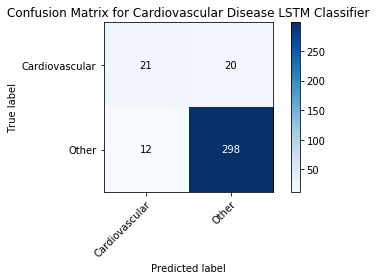

In [13]:
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = [int_to_intent(y_class) for y_class in unique_labels(y_test, y_pred)]

    fig, ax = plt.subplots()
#     fig.set_figheight(15)
#     fig.set_figwidth(15)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_test, y_pred, classes=class_labels
                      , title='Confusion Matrix for Cardiovascular Disease LSTM Classifier')